In [34]:
import tensorflow
from tensorflow.keras.preprocessing import image
from PIL import  Image
import cv2
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import  load_model
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
import numpy as np
import pandas as pd 
from numpy.linalg import norm
import os
import re
import pickle
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

### First we will explore pretrained model with top layer,s. Loading model with imagenet weights

In [2]:
# LOading Resnet50 with Top layer, means for 1k classes of imagenet
model = ResNet50(weights='imagenet',input_shape=(224,224,3))

# MY test image for this model
img_path = 'nova-scotia-duck-tolling-retriever-4992428.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)     # (224, 224, 3)
x = np.expand_dims(x, axis=0)   # (1, 224, 224, 3)
x = preprocess_input(x)         # (1, 224, 224, 3)

# Getting the prediction from the pretrain the model
pred = model.predict(x)



1/1 [==============================] - 2s 2s/step


In [3]:
# Finding label indexing to extract the name of the label from the list
label_index = np.argmax(pred,axis=1)[0]

In [4]:
# Reading the labels to interpret the prediction
with open(r'C:\Users\Ranjit\Desktop\Data_science_coding_examples\Deep learning\Transfer Learning\Image_classification\imagenet1000_clsidx_to_labels.txt','r') as file:
    data = file.read()

In [5]:
print("This is the image of :-", {re.sub('[^a-zA-z  -]','',data.split('\n')[label_index].split(':')[1])} )

This is the image of :- {' flat-coated retriever'}


### And Now we will explore, how we can use these pre-trained model with custome dataset.

In [6]:
Model = ResNet50(weights='imagenet',input_shape=(224,224,3),include_top=False)
#Loading the model without top layer. means only loading

In [7]:
Data_path = r"C:\Users\Ranjit\Desktop\Data_science_coding_examples\Deep learning\CNN\Dog_cat\Data\images"
os.listdir(Data_path)

['cats', 'dogs']

In [8]:
print("Total No. of Cat Images :",len(os.listdir(os.path.join(Data_path,'cats'))))


Total No. of Cat Images : 349


In [9]:
print("Total No. of Cat Images :",len(os.listdir(os.path.join(Data_path,'dogs'))))


Total No. of Cat Images : 348


In [10]:
# preparing the File Path 

path_dict = {'cats':[],'dogs':[]}
for dir in os.listdir(Data_path):
    directory_path = os.path.join(Data_path,dir)
    for images in os.listdir(directory_path):
        path_dict[dir].append(os.path.join(directory_path,images))

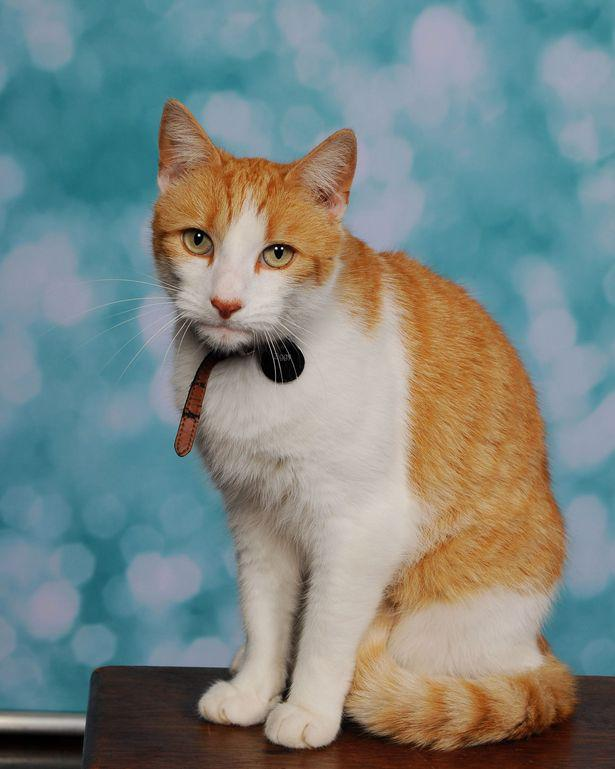

In [11]:
cat_image_demo = Image.open(path_dict['cats'][0])
cat_image_demo

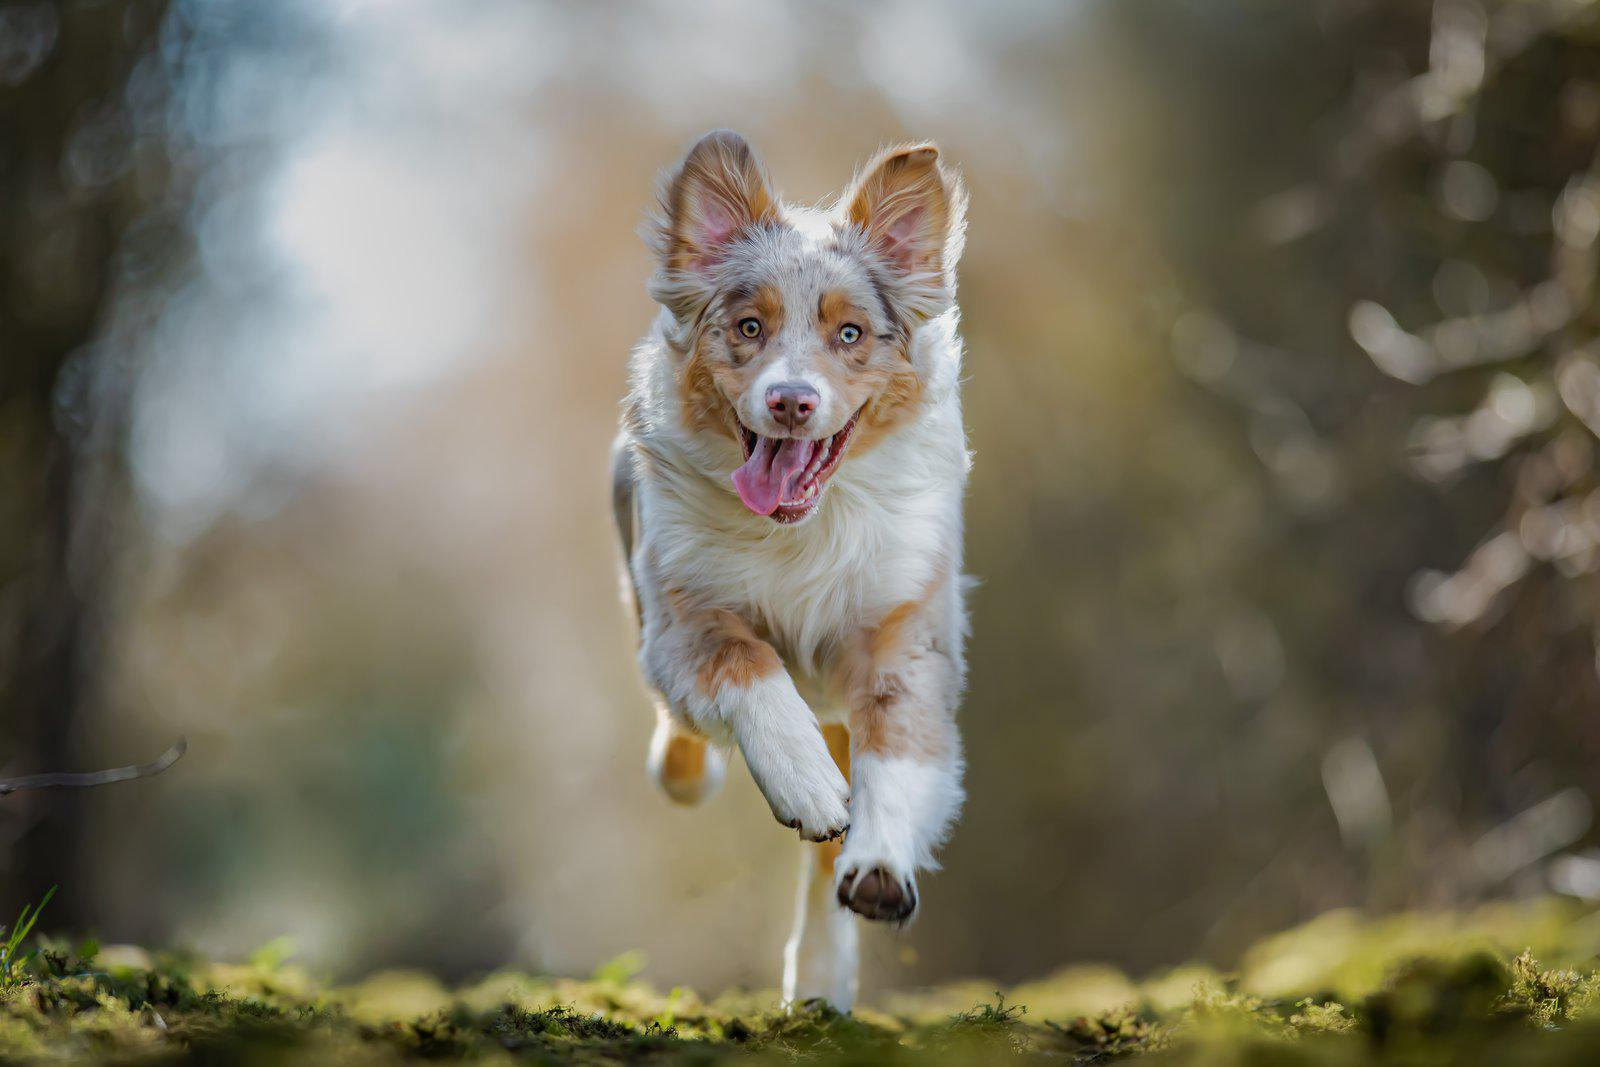

In [12]:
dog_image_demo = Image.open(path_dict['dogs'][0])
dog_image_demo

In [13]:
## Now we are Reading the Image as an array
img_arr_lst = []
labels = []
for key , valu in path_dict.items():
    for path in valu:
        img_arr = cv2.imread(path)
        resized_img_arr = cv2.resize(img_arr,(224,224))
        img_arr_lst.append(resized_img_arr)
        labels.append(key)

In [14]:
array_image = np.array(img_arr_lst)
labels = np.array(labels)
array_image.shape          ,    labels.shape  

((697, 224, 224, 3), (697,))

In [15]:
#Label Encoding
labels = np.array([1 if item=='dogs' else 0 for item in list(labels)])

In [16]:
# Train Test splitting the dataset
x_train , x_test , y_train , y_test = train_test_split(array_image,labels,test_size=0.2,random_state=42)

In [17]:
#Normalizing the pixel value in between 0 - 1 range
x_train = x_train/255
x_test = x_test/255
x_train.shape , y_train.shape

# If you want to Normalize in btw -1  to +1
# x_test = (x_test-127.5)/127.5

((557, 224, 224, 3), (557,))

In [18]:
### This is Summary of my Resnet50 model
Model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [23]:
# FIRST FReeze THE LAYERS OF ResNet50 to training

for layer in Model.layers:
    layer.trainable = False

In [28]:
# Now we are Defining a complete CNN architecture model with Resnet50
# To perform Binary classification on custome dataset.

custome_model = Sequential([Model,
layers.Flatten(),
layers.Dense(units=64,activation='relu'),
layers.Dense(units=48,activation='relu'),
layers.Dense(units=1,activation='sigmoid')])

custome_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
custome_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 64)                6422592   
                                                                 
 dense_7 (Dense)             (None, 48)                3120      
                                                                 
 dense_8 (Dense)             (None, 1)                 49        
                                                                 
Total params: 30013473 (114.49 MB)
Trainable params: 6425761 (24.51 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [25]:
x_train.shape , y_train.shape

((557, 224, 224, 3), (557,))

In [30]:
history = custome_model.fit(x_train,y_train,initial_epoch=2,epochs=10,validation_data=(x_test,y_test))

Epoch 3/10
18/18 [==============================] - 78s 4s/step - loss: 0.6847 - accuracy: 0.5835 - val_loss: 0.6497 - val_accuracy: 0.6071
Epoch 4/10
18/18 [==============================] - 75s 4s/step - loss: 0.6397 - accuracy: 0.6194 - val_loss: 0.6543 - val_accuracy: 0.6500
Epoch 5/10
18/18 [==============================] - 75s 4s/step - loss: 0.6107 - accuracy: 0.6571 - val_loss: 0.7105 - val_accuracy: 0.5500
Epoch 6/10
18/18 [==============================] - 74s 4s/step - loss: 0.5943 - accuracy: 0.6679 - val_loss: 1.0747 - val_accuracy: 0.4500
Epoch 7/10
18/18 [==============================] - 71s 4s/step - loss: 0.7742 - accuracy: 0.5763 - val_loss: 0.9136 - val_accuracy: 0.5643
Epoch 8/10
18/18 [==============================] - 71s 4s/step - loss: 0.7923 - accuracy: 0.5781 - val_loss: 0.7540 - val_accuracy: 0.5929
Epoch 9/10
18/18 [==============================] - 89s 5s/step - loss: 0.6262 - accuracy: 0.6176 - val_loss: 0.6975 - val_accuracy: 0.6214
Epoch 10/10
18/18 [=

In [35]:
Training_details = pd.DataFrame(history.history)
Training_details

,loss,accuracy,val_loss,val_accuracy
0,0.684736,0.583483,0.649749,0.607143
1,0.639725,0.619390,0.654265,0.650000
2,0.610679,0.657092,0.710491,0.550000
3,0.594336,0.667864,1.074727,0.450000
4,0.774187,0.576302,0.913606,0.564286
5,0.792316,0.578097,0.754033,0.592857
6,0.626158,0.617594,0.697489,0.621429
7,0.557372,0.687612,0.634381,0.635714


<Axes: >

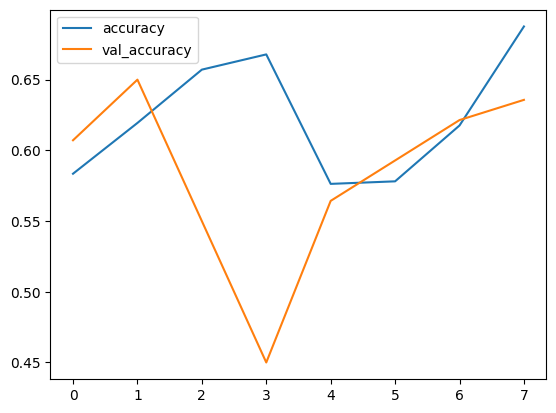

In [36]:
Training_details[['accuracy','val_accuracy']].plot()

<Axes: >

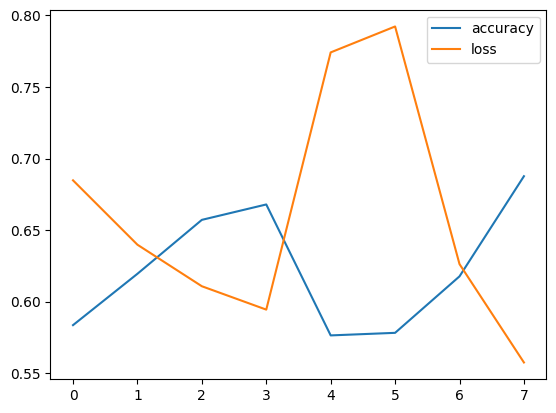

In [37]:
Training_details[['accuracy','loss']].plot()

<Axes: >

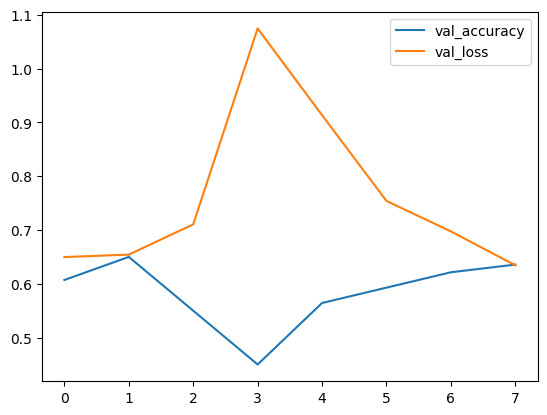

In [38]:
Training_details[['val_accuracy','val_loss']].plot()

In [39]:
# Checking Training accuracy
Training_accuracy = custome_model.evaluate(x_train,y_train)
Training_accuracy

18/18 [==============================] - 65s 4s/step - loss: 0.5380 - accuracy: 0.7199


[0.5379964709281921, 0.7199282050132751]

In [40]:
# <<<<<<<<<<<<<<<  MODEL EVALUATION  >>>>>>>>>>>>>>>
# Checking Testing accuracy
Testing_accuracy = custome_model.evaluate(x_test,y_test)
Testing_accuracy

5/5 [==============================] - 14s 3s/step - loss: 0.6344 - accuracy: 0.6357


[0.6343806385993958, 0.6357142925262451]

In [41]:
# Getting The Prediction From our Model, which we have trained
preds = custome_model.predict(x_test)

5/5 [==============================] - 16s 3s/step


In [42]:
# <<<<<<<<<<< PREDICTION  >>>>>>>>>>>
# Estimating Prediction for our testing data.
predictions = (preds>0.5).astype(int).ravel()

In [44]:
confusion_matrix(y_test,predictions)
# MODEL EVALUATION TECHNIQU CONFUSION MATRIX

array([[64, 14],
       [37, 25]], dtype=int64)

In [45]:
print(classification_report(y_test,predictions))
# CLASSIFICATION REPORT FOR MODEL EVALUATION

              precision    recall  f1-score   support

           0       0.63      0.82      0.72        78
           1       0.64      0.40      0.50        62

    accuracy                           0.64       140
   macro avg       0.64      0.61      0.61       140
weighted avg       0.64      0.64      0.62       140



In [ ]:
# TO SAVE YOUR MODEL, .h5  EXTENSION OF THE TENSORFLOW 
custome_model.save('Resnet_finetune_for_binary_clasi.h5')
model_loaded = load_model('Resnet_finetune_for_binary_clasi.h5')

#### Model Training with HyperParameterTurning and Regularization, code will be uploaded soon, so that you can enhace your accuracy.

THANK YOU 🤍